# Historical and future simulation of hailstorms in Australia

In [1]:
%cd ~/git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import xarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client

## Settings

In [3]:
base_dir = '/g/data/up6/tr2908/hist_future_hail/'  # Data base directory.
hist_years = np.arange(1980, 1999)  # Historical years.
fut_years = np.arange(2080, 2100)  # Future years.
sims_dir = f'{base_dir}/WRF_v4.4/simulations/cities/'  # Simulation directory.
data_dir = f'{base_dir}/xu_data'  # Xu et al. data directory.
plt.show()  # Start the plotting engine.
plt.rcParams['font.size'] = 12  # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37137,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:35999,Total threads: 4
Dashboard: http://127.0.0.1:45297/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:33805,


## Environment

In [5]:
!module list

Currently Loaded Modulefiles:
 1) conda/analysis3-24.07(analysis3-unstable)   2) R/4.3.1   3) pbs  
>

In [6]:
!python --version

Python 3.10.16


## Temperature increases by year

We use a temperature-based framework to talk about future changes. To get mean near-surface air temperature we use the weighted mean (weighted by cosine of latitude) in the Xu et al SSP2-4.5 dataset. The following code can be used to generate this dataset after the lnd files for historical and ssp245 have been wget and unzipped into /scratch.

In [7]:
mean_temps = hf.mean_temp_per_year(infiles={'Historical': '/scratch/up6/tr2908/xu/lnd.historical.*.nc',
                                            'SSP2-4.5': '/scratch/up6/tr2908/xu/lnd.ssp245.*.nc'},
                                   outfile=f'{data_dir}/mean_temperature_by_year.nc')

The reference temperature of 13.6 C is the mean temperature 1850-1900, annual using [CMIP6 35-model ensemble](https://interactive-atlas.ipcc.ch/permalink/Gzfztqvg).

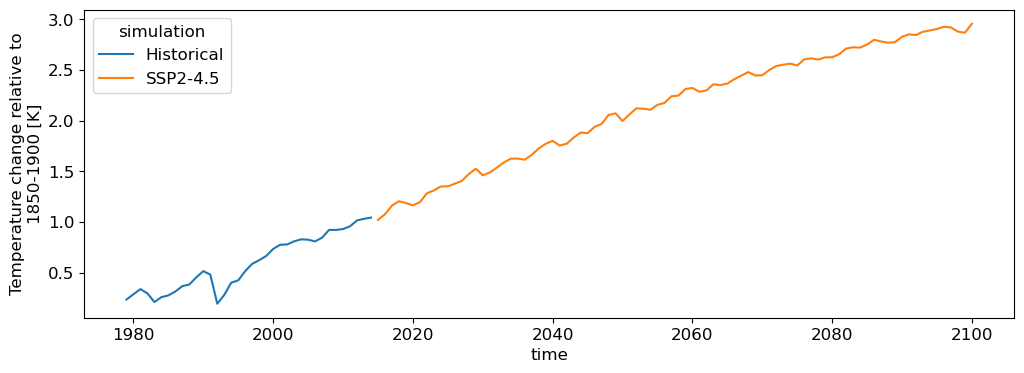

In [8]:
reference_temp = (
    13.6 + 273.15
)  # Mean temperature 1850-1900 using CMIP6 ensemble, annual, median of 35 models (https://interactive-atlas.ipcc.ch/regional-information#eyJ0eXBlIjoiQVRMQVMiLCJjb21tb25zIjp7ImxhdCI6MTc0MTAxMCwibG5nIjotNTU4MzgyNSwiem9vbSI6MywicHJvaiI6IkVQU0c6NTQwMzAiLCJtb2RlIjoiY29tcGxldGVfYXRsYXMifSwicHJpbWFyeSI6eyJzY2VuYXJpbyI6Imhpc3RvcmljYWwiLCJwZXJpb2QiOiJwcmVJbmR1c3RyaWFsIiwic2Vhc29uIjoieWVhciIsImRhdGFzZXQiOiJIQ01JUDYiLCJ2YXJpYWJsZSI6InRhcyIsInZhbHVlVHlwZSI6IlZBTFVFIiwiaGF0Y2hpbmciOiJTSU1QTEUiLCJyZWdpb25TZXQiOiJhcjYiLCJiYXNlbGluZSI6InByZUluZHVzdHJpYWwiLCJyZWdpb25zU2VsZWN0ZWQiOls0NywxLDMsNCw1LDIsMCw1MCw4LDcsNiw0NiwyOCwxNiwxNywxOCwxOSwzMiwyOSwzMCwzNCwzMywzNSwzMSwyMCwyMSwzNiwyMiw1MSwxMSwxMCw5LDQ4LDQ5LDEzLDE0LDI1LDI2LDI0LDUzLDM3LDU0LDM4LDM5LDQwLDQxLDQyLDU3LDEyLDUyLDIzLDU1LDI3LDU2LDQzLDE1LDQ1LDQ0XX0sInBsb3QiOnsiYWN0aXZlVGFiIjoidGFibGUiLCJzaG93aW5nIjp0cnVlLCJtYXNrIjoibm9uZSIsInNjYXR0ZXJZTWFnIjoiVkFMVUUiLCJzY2F0dGVyWVZhciI6InRhcyJ9fQ==)
mean_temps['change'] = mean_temps.tas - reference_temp
mean_temps.change.attrs = {'long_name': 'Temperature change relative to 1850-1900', 'units': 'K'}
mean_temps.change.plot(figsize=(12, 4), hue='simulation')
plt.show()

In [9]:
mean_temps_fut = mean_temps.sel(simulation='SSP2-4.5')
mean_temps_hist = mean_temps.sel(simulation='Historical')
mean_change_fut_years = (
    mean_temps_fut.sel(year=slice(fut_years.min(), fut_years.max() + 1)).change.mean().values
)
mean_change_hist_years = (
    mean_temps.sel(year=slice(hist_years.min(), hist_years.max() + 1)).change.mean().values
)
print(
    f'Mean temperature change over the historical years selected here ({hist_years.min()}-{hist_years.max()+1}) is {np.round(mean_change_hist_years, 2)} K over pre-industrial.'
)
print(
    f'Mean temperature change over the future years selected here ({fut_years.min()}-{fut_years.max()+1}) is {np.round(mean_change_fut_years, 2)} K over pre-industrial.'
)
print(
    f'Change in mean temperature between epochs is then {np.round(mean_change_fut_years - mean_change_hist_years, 2)} K.'
)

Mean temperature change over the historical years selected here (1980-1999) is 0.39 K over pre-industrial.
Mean temperature change over the future years selected here (2080-2100) is 2.81 K over pre-industrial.
Change in mean temperature between epochs is then 2.42 K.


In [ ]:
hf.plot_wrf_domains(wps_files = {f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d01.nc': ('solid', 'orange'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d02.nc': ('solid', 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d03.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d04.nc': ('solid', 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d05.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d06.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d07.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d01.nc': ((0, (5, 2)), 'orange'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d02.nc': ((0, (5, 2)), 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d03.nc': ((0, (5, 2)), 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d04.nc': ((0, (5, 2)), 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d05.nc': ((0, (5, 2)), 'blue')},
                    pts=hf.cities, figsize=(12,8),
                    labels={'Perth': ('a', (8, -5)),
                            'Kalgoorlie': ('b', (-8, -10)),
                            'Adelaide': ('c', (-13, -12)),
                            'Melbourne': ('d', (6, 3)),
                            'Canberra': ('e', (-0.5, 5.5)),
                            'Sydney': ('f', (9, -3)),
                            'Brisbane': ('g', (-9, -3))},
                    file='paper/supporting info/figures/domains.pdf')

Max factor is 1.07 in domain 8.
Min factor is 1.0 in domain 3.


## Changes by city

In [ ]:
maxima_cities = hf.process_maxima(sim_dir='/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/cities/')

In [ ]:
maxima_remote = hf.process_maxima(sim_dir='/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/remote/',
                                  domains={'Kalgoorlie': 3, 'Adelaide': 5},
                                  time_adjust={'Kalgoorlie': 8, 'Adelaide': 10},
                                  results_dir='/g/data/up6/tr2908/hist_future_hail/results/',
                                  variables=['hailcast_diam_max', 'wind_10m'],
                                  time_adjust_mins={'Kalgoorlie': 0, 'Adelaide': 30},
                                  file_dir='paper/supporting info/figures/')

In [13]:
maxima = xarray.merge([maxima_cities, maxima_remote])

In [ ]:
hf.plot_maxima(maxima=maxima, variable='hailcast_diam_max', scale_label='Maximum hail size [mm]', 
               file='paper/main/figures/max_hail_sizes_by_domain.pdf', cbar_max=120)

In [ ]:
hf.plot_maxima(maxima=maxima, variable='wind_10m', factor=3.6, scale_label='10 m wind [km h$^{-1}$]', cbar_min=36,
               file = 'paper/supporting info/figures/max_10m_winds_by_domain.pdf')

In [ ]:
print(f'Percentage of hail points with very large hail removed: {maxima.perc_large_hail.max().values}')
assert maxima.perc_large_hail.max() < 0.006, 'Paper statement that < 0.006\% of large hail was removed is not true.'

## Comparison of radar data to modelled hail for historical period

Opened dataset contains hail and "no-hail" reports so filter by MESH > 21 before use.

In [ ]:

rad_data = pd.read_feather('/g/data/w42/jake9490/full_hail_dataset.feather')
rad_data = rad_data[rad_data.mesh > 21]
rad_data

In [18]:
res = []
for domain in maxima.domain.values:
    m = maxima.sel(domain=domain)
    lat_range = [float(m.latitude.min().values), float(m.latitude.max().values)]
    lon_range = [float(m.longitude.min().values), float(m.longitude.max().values)]

    r = rad_data.loc[rad_data.latitude >= lat_range[0]]
    r = r.loc[r.latitude <= lat_range[1]]
    r = r.loc[r.longitude >= lon_range[0]]
    r = r.loc[r.longitude <= lon_range[1]]
    r = r.loc[np.isin(r.time.dt.month, [10,11,12,1,2])]

    r['day'] = r.time.dt.strftime('%Y-%m-%d')
    r['year'] = r.time.dt.strftime('%Y')
    r = r.dropna()
    daily = r.groupby('day').max()
    daily['season'] = (daily.time - np.timedelta64(60, 'D')).dt.year

    yearly = daily.groupby('season').max()
    yearly_count = daily.groupby('season').count()

    num_lat = ((r.latitude.max() - r.latitude.min()) / 0.25) + 1
    num_lon = ((r.longitude.max() - r.longitude.min()) / 0.25) + 1
    num_points = num_lat * num_lon
    cov_points = len(r.drop_duplicates(subset=['latitude', 'longitude']))
    perc_covered = cov_points / num_points * 100

    res.append(pd.DataFrame({'perc_covered': perc_covered,
                             'perc_over_50': np.mean(daily.mesh > 50) * 100,
                             'perc_over_100': np.mean(daily.mesh > 100) * 100,
                             'return_period_100': np.nan if np.sum(yearly.mesh > 100) == 0 else len(yearly.index.unique()) / np.sum(yearly.mesh > 100),
                             'return_period_50': np.nan if np.sum(yearly.mesh > 50) == 0 else len(yearly.index.unique()) / np.sum(yearly.mesh > 50),
                             'average_hail_days': yearly_count.mesh.mean()},
                             index=[domain]))
    
res = pd.concat(res)
res.to_latex('paper/supporting info/tables/radar_stats.tex', float_format="%.1f")